# Control a Robot

When gravity is enabled in the simulator, a robot arm will naturally collapse if no control is applied. This is not a bug, it's just physics. In this notebook, we’ll look at how to bring the robot arm under control.

### What You Will Learn

1. PD Control and Commanding Robots \
Experience how Genesis provides built-in Proportional–Derivative (PD) controllers for applying stable joint-level control.

2. Control Joints and DOFs \
Use the **Franka Emika Panda** as an example: 7 revolute joints + 2 prismatic joints = 9 DOFs.

3. Tuning Control Gains \
Learn to configure proportional (`kp`), derivative (`kv`), and force-limit parameters for each DOF.

In [1]:
# Suppress warning messages for clearer output
import warnings
import os

os.environ["TI_LOG_LEVEL"] = "error"
warnings.filterwarnings("ignore")

## Init and Create a Scene

In Lab 1, we used default setting when creating thhe scene. Here we use more advanced settings.

You can customize the **Simulator** and **Visualizer** through detailed configuration options when creating a scene.

**Simulator options** define the physical simulation behavior. Common parameters include:

* **dt** – Duration of each simulation step (in seconds)
* **gravity** – Gravity force vector (N/kg)
* **floor_height** – Ground plane height

**Visualizer options** control the virtual camera and rendering behavior. Key parameters:

* **camera_pos** – Initial position of the camera
* **camera_lookat** – Target point the camera focuses on
* **camera_fov** – Field of view (in degrees)
* **max_FPS** – Set max FPS.


In [2]:
import numpy as np
import genesis as gs

########################## init ##########################
gs.init(backend=gs.vulkan, theme='light')

########################## create a scene ##########################
scene = gs.Scene(
    viewer_options=gs.options.ViewerOptions(
        camera_pos=(0, -3.5, 2.5),
        camera_lookat=(0.0, 0.0, 0.5),
        camera_fov=30,
        max_FPS=60,
    ),
    sim_options=gs.options.SimOptions(
        dt=0.01,
    ),
    show_viewer=False,
)

[Genesis] [09:57:03] [INFO] ╭───────────────────────────────────────────────╮
[Genesis] [09:57:03] [INFO] │┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈ Genesis ┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈│
[Genesis] [09:57:03] [INFO] ╰───────────────────────────────────────────────╯
[Genesis] [09:57:03] [INFO] Consider setting 'performance_mode=True' in production to maximise runtime speed, if significantly increasing compilation time is not a concern.
[Genesis] [09:57:03] [INFO] Running on [AMD Radeon Graphics] with backend gs.vulkan. Device memory: 60.75 GB.
[Genesis] [09:57:03] [INFO] 🚀 Genesis initialized. 🔖 version: 0.3.3, 🌱 seed: None, 📏 precision: '32', 🐛 debug: False, 🎨 theme: 'light'.
[Genesis] [09:57:03] [INFO] Scene <bb06885> created.


## Add Entities and Build the Scene

Just like what we did in Lab 1, we add a **plane**, an **arm**, and a **camera** to the scene, and then build the scene.

In [3]:
########################## entities ##########################
plane = scene.add_entity(
    gs.morphs.Plane(),
)
franka = scene.add_entity(
    gs.morphs.MJCF(
        file="xml/franka_emika_panda/panda.xml",
    ),
)
cam = scene.add_camera(
    res=(640, 480),
    pos=(3.5, 0.0, 2.5),
    lookat=(0, 0, 0.5),
    fov=30,
    GUI=True,
)

########################## build ##########################
scene.build()
print("Successfully built the scene.")

[Genesis] [10:02:08] [INFO] Adding <gs.RigidEntity>. idx: 0, uid: <1a7f5ec>, morph: <gs.morphs.Plane>, material: <gs.materials.Rigid>.
[Genesis] [10:02:08] [INFO] Adding <gs.RigidEntity>. idx: 1, uid: <84432a7>, morph: <gs.morphs.MJCF(file='/opt/conda/envs/py_3.12/lib/python3.12/site-packages/genesis/assets/xml/franka_emika_panda/panda.xml')>, material: <gs.materials.Rigid>.
[Genesis] [10:02:09] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint1`
[Genesis] [10:02:09] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias for joint `finger_joint1`.
[Genesis] [10:02:09] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint2`
[Genesis] [10:02:09] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias for joint `finger_joint2`.
[Genesis] [10:02:09] [INFO] Applying o

amdgpu: os_same_file_description couldn't determine if two DRM fds reference the same file description.
If they do, bad things may happen!


## Control Joints and DOFs

In robotics, the terms **joint** and **degree of freedom (DOF)** are related but not quite the same. 

A joint is the physical connection between two parts (or links) of a robot that allows relative motion. For example, a hinge, a slider, or a ball-and-socket connection. Each joint enables certain types of movement.

A degree of freedom (DOF), on the other hand, refers to the number of independent ways a joint (or the entire robot) can move. For instance, a revolute (rotational) joint has one DOF because it can rotate around a single axis, while a spherical joint has three DOFs, it can rotate around three perpendicular axes.

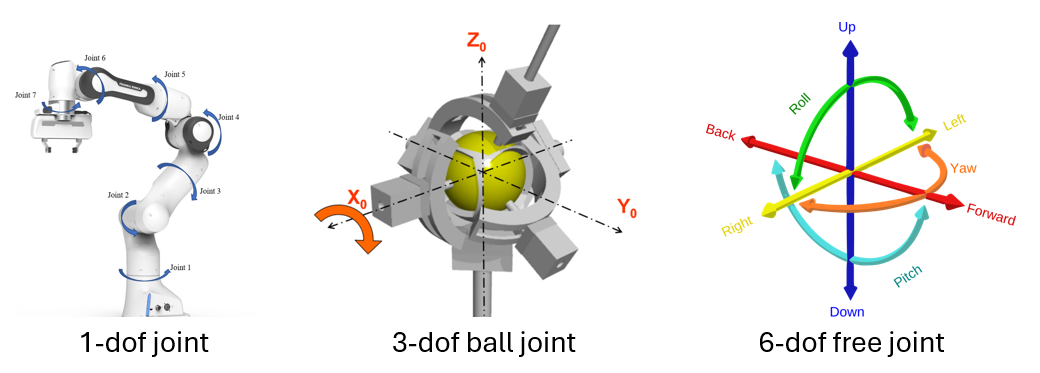

Take Franka Panda arm for example, it has 7 revolute joints in the arm and 2 prismatic joints in its gripper. Since each joint has only 1 DOF, the robot ends up with 9 DOFs in total.

In [15]:
jnt_names = [
    'joint1',
    'joint2',
    'joint3',
    'joint4',
    'joint5',
    'joint6',
    'joint7',
    'finger_joint1',
    'finger_joint2',
]

dofs_idx_temp = [franka.get_joint(name).dofs_idx_local for name in jnt_names]
dofs_idx = [idx for sublist in dofs_idx_temp for idx in sublist]

print(dofs_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


## Control Gains

Control gains decide how much torque the controller applies to reduce errors in position or velocity. URDF/MJCF files usually provide default values, but manual tuning is often necessary for stable, realistic control.

Genesis exposes three functions:

* `.set_dofs_kp` — proportional gains
* `.set_dofs_kv` — derivative gains
* `.set_dofs_force_range` — safety limits on torque/force

Together, `kp` and `kv` form the **PD controller**:

For Franka, the arm joints (joint1–joint7) use higher gains for stiffness and precision, and the finger joints use lower gains so they feel softer and safer when grasping objects. 

A typical setup looks like this:

In [5]:
############ Optional: set control gains ############

# set positional gains
franka.set_dofs_kp(
    kp             = np.array([4500, 4500, 3500, 3500, 2000, 2000, 2000, 100, 100]),
    dofs_idx_local = dofs_idx,
)
# set velocity gains
franka.set_dofs_kv(
    kv             = np.array([450, 450, 350, 350, 200, 200, 200, 10, 10]),
    dofs_idx_local = dofs_idx,
)
# set force range for safety
franka.set_dofs_force_range(
    lower          = np.array([-87, -87, -87, -87, -12, -12, -12, -100, -100]),
    upper          = np.array([ 87,  87,  87,  87,  12,  12,  12,  100,  100]),
    dofs_idx_local = dofs_idx,
)

## Directly Setting DOF Positions

It’s also possible to set DOF positions directly with `.set_dofs_position`. This instantly changes the robot state and bypasses physics. This can be useful for resets or demonstrations, but it may create unrealistic motion that violates physical laws.

To avoid overly lengthy log information, we will not print the detailed logs here, we’ll use a progress bar to indicate the progress.


In [12]:
import logging
from tqdm import tqdm

# Set logger to warning to avoid log info.
gs.logger._logger.setLevel(logging.WARNING)

# Camera recording
rgb, depth, segmentation, normal = cam.render(rgb=True, depth=True, segmentation=True, normal=True)
cam.start_recording()

# Hard reset
for i in tqdm(range(150), ncols=100):
    if i < 50:
        franka.set_dofs_position(np.array([1, 1, 0, 0, 0, 0, 0, 0.04, 0.04]), dofs_idx)
    elif i < 100:
        franka.set_dofs_position(np.array([-1, 0.8, 1, -2, 1, 0.5, -0.5, 0.04, 0.04]), dofs_idx)
    else:
        franka.set_dofs_position(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0]), dofs_idx)
    cam.render()
    scene.step()

100%|█████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 34.14it/s]


## Using the PD Controller

To respect physics, use the `control_*` APIs instead. These send commands to the PD controller rather than overwriting the state. We can save it as a complete video and check the result.

In [13]:
# PD control
for i in tqdm(range(1250), ncols=100):
    if i == 0:
        franka.control_dofs_position(
            np.array([1, 1, 0, 0, 0, 0, 0, 0.04, 0.04]),
            dofs_idx,
        )
    elif i == 250:
        franka.control_dofs_position(
            np.array([-1, 0.8, 1, -2, 1, 0.5, -0.5, 0.04, 0.04]),
            dofs_idx,
        )
    elif i == 500:
        franka.control_dofs_position(
            np.array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
            dofs_idx,
        )
    elif i == 750:
        # control first dof with velocity, and the rest with position
        franka.control_dofs_position(
            np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])[1:],
            dofs_idx[1:],
        )
        franka.control_dofs_velocity(
            np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0])[:1],
            dofs_idx[:1],
        )
    elif i == 1000:
        franka.control_dofs_force(
            np.array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
            dofs_idx,
        )

    cam.render()
    scene.step()

cam.stop_recording(save_to_filename="Videos/video_02.mp4", fps=60)

100%|███████████████████████████████████████████████████████████| 1250/1250 [00:29<00:00, 42.31it/s]


## Show the video

In the video, you’ll first see three relatively rigid movements, these are discontinuous actions created using set_dofs_position. The following smoother, continuous motions are produced by the control_* APIs. Therefore, when creating robots in a virtual environment that behave according to physical laws, we usually use the control_* APIs to write the program.

In [14]:
from IPython.display import Video
Video(url="Videos/video_02.mp4")